In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk07_centrality.ipynb")

In [141]:
#!pip install --upgrade networkx

In [142]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd

plt.style.use('fivethirtyeight')

import networkx as nx
import pickle

%matplotlib inline

np.random.seed(99)

# Homework 07

## Calculating betweenness centrality from scratch

Consider the network generated by the following code.

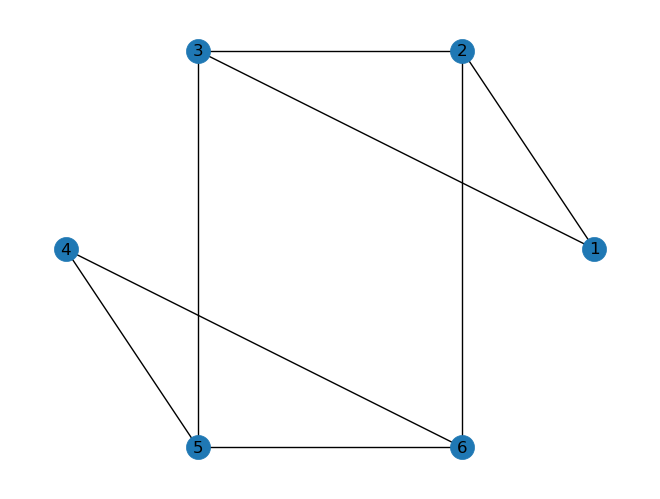

In [146]:
test_net = nx.Graph([(1,2), (1, 3), (2,3), (4,5), (4,6), (5,6), (3,5), (2,6)])
nx.draw_circular(test_net, with_labels=True)

<!-- BEGIN QUESTION -->

# Question 1

Fill in the table below with the distance and the number of shortest paths between each pair of vertices. (For example, if there are three shortest paths each of length 2, write 2 (3) in the table.)

| &nbsp;  | node 1 | node 2 | node 3 | node 4 | node 5 | node 6 |
|  ------ | -----  | ------ | ------ | ------ | ------ | ------ |
|  node 1 |   -    |  ? (?) |  ? (?) |  ? (?) |  ? (?) |  ? (?) |
|  node 2 |   -    |  -     |  ? (?) |  ? (?) |  ? (?) |  ? (?) |
|  node 3 |   -    |  -     |   -    |  ? (?) |  ? (?) |  ? (?) |
|  node 4 |   -    |  -     |   -    |   -    |  ? (?) |  ? (?) |
|  node 5 |   -    |  -     |   -    |   -    |   -    |  ? (?) |

_Type your answer here, replacing the question marks._

<!-- END QUESTION -->



# Question 2
Calculate the betweenness centrality for node 3 and for node 5 by hand, and fill the answers in below.



In [151]:
# BEGIN SOLUTION NO PROMPT
bc_node3 = 2
bc_node5 = 2
# END SOLUTION
""" # BEGIN PROMPT
bc_node3 = ...
bc_node5 = ...
"""; # END PROMPT

In [ ]:
grader.check("q2")

# Question 3

Check your calculation using the `nx.betweenness_centrality` function.  
*[NB: be sure to set the normalized argument to False]*.



In [155]:
# BEGIN SOLUTION NO PROMPT
test_bc = nx.betweenness_centrality(test_net, normalized=False) # SOLUTION
# END SOLUTION
""" # BEGIN PROMPT
test_bc = ...
"""; # END PROMPT
test_bc

{1: 0.0, 2: 2.0, 3: 2.0, 4: 0.0, 5: 2.0, 6: 2.0}

In [ ]:
grader.check("q3")

## Epidemic models and centrality among US Legislators

In this homework, we'll be investigating patterns of connections on Twitter among Members of Congress (MOC). This dataset comes from the official Twitter accounts of members of Congress in the fall of 2016. We've made a few simplifications here:

* On Twitter, following is a *directed relation*. So person A can follow person B without person B necessarily following person A. Here, we've taken these directed relationships and turned them into an undirected network.
* Almost every Senator and Representative is in this dataset, but a few are missing; we'll ignore these missing people here.

The goal of the homework is to evaluate how well different metrics for centrality predict outcomes in an SIR epidemic model. The idea is that 'good' measures of centrality should be able to tell us which nodes play an important role in the spread of a disease or idea through a network.

## Exploratory analysis of the dataset

The nodes in the `official_congress_twitter` network have attributes. These attributes include:

* `official_full` - the MOC's full name
* `gender` - the MOC's gender
* `party` - the MOC's political party
* `state` - the MOC's state
* `type` - either `sen` for Senator or `rep` for Representative

Let's start by loading the dataset.

In [163]:
try:
    official_congress_twitter = pickle.load(open('../data/congress-twitter/us_congress_2016_twitter_nx2.pickle', 'rb'))
except:
    official_congress_twitter = pickle.load(open('./us_congress_2016_twitter_nx2.pickle', 'rb'))
    pass

## Exploratory analysis of the dataset

First, we'll explore the dataset, focusing on different ways to understand centrality.

In order to look more closely at the attributes of the members of Congress, we'll make use of this function:

In [167]:
def nodes_to_table(g):
    """
    Given a network `g`, return a Table that has all of the attributes of the
    nodes in the network
    """
    
    df = {}
    df['node_id'] = list(g.nodes())
    
    # assume all nodes have the same attributes
    #att_names = g.node[df['node_id'][0]].keys()
    att_names = g.nodes[df['node_id'][0]].keys()
    
    for att in att_names:
        df[att] = [node[1][att] for node in g.nodes(data=True)]
    
    df = pd.DataFrame(df)
    
    return Table.from_df(df)

The `nodes_to_table` function makes a Table that has the attributes of all of the nodes in the network it is given. We can use it like this:

In [169]:
moc_data1 = nodes_to_table(official_congress_twitter)

moc_data1

node_id,state,nickname,url,last,religion,district,party,class,birthday,official_full,phone,bioguide,start,caucus,contact_form,twitter,suffix,type,state_rank,rss_url,address,office,end,fax,gender,first,middle
2974648323,CA,nan,https://knight.house.gov,Knight,nan,25,Republican,nan,1966-12-17,Stephen Knight,202-225-1956,K000387,2015-01-06,nan,nan,2.97465e+09,nan,rep,nan,nan,1023 Longworth HOB; Washington DC 20515-0525,1023 Longworth House Office Building,2017-01-03,202-226-0683,M,Steve,nan
2253968388,AL,nan,https://byrne.house.gov,Byrne,nan,1,Republican,nan,1955-02-16,Bradley Byrne,202-225-4931,B001289,2015-01-06,nan,https://byrne.house.gov/contact/email-me,2.25397e+09,nan,rep,nan,nan,119 Cannon HOB; Washington DC 20515-0101,119 Cannon House Office Building,2017-01-03,202-225-0562,M,Bradley,nan
236511574,MI,nan,http://www.peters.senate.gov,Peters,nan,nan,Democrat,2,1958-12-01,Gary C. Peters,202-224-6221,P000595,2015-01-06,nan,nan,2.36512e+08,nan,sen,junior,nan,724 Hart Senate Office Building Washington DC 20510,724 Hart Senate Office Building,2021-01-03,nan,M,Gary,C.
161411080,CA,nan,http://napolitano.house.gov,Napolitano,Roman Catholic,32,Democrat,nan,1936-12-04,Grace F. Napolitano,202-225-5256,N000179,2015-01-06,nan,https://napolitano.house.gov/contact-me/email-me,1.61411e+08,nan,rep,nan,http://napolitano.house.gov/rss.xml,1610 Longworth HOB; Washington DC 20515-0532,1610 Longworth House Office Building,2017-01-03,202-225-0027,F,Grace,F.
402719755,NV,nan,http://amodei.house.gov,Amodei,nan,2,Republican,nan,1958-06-12,Mark E. Amodei,202-225-6155,A000369,2015-01-06,nan,https://amodei.house.gov/contact-us,4.0272e+08,nan,rep,nan,http://amodei.house.gov/common/rss//?rss=49,332 Cannon HOB; Washington DC 20515-2802,332 Cannon House Office Building,2017-01-03,202-225-5679,M,Mark,E.
442824717,MA,nan,http://neal.house.gov,Neal,Roman Catholic,1,Democrat,nan,1949-02-14,Richard E. Neal,202-225-5601,N000015,2015-01-06,nan,https://forms.house.gov/neal/webforms/Contact_Form.shtml,4.42825e+08,nan,rep,nan,http://neal.house.gov/index.php?format=feed&type=rss,341 Cannon HOB; Washington DC 20515-2101,341 Cannon House Office Building,2017-01-03,202-225-8112,M,Richard,E.
267854863,LA,nan,http://richmond.house.gov,Richmond,nan,2,Democrat,nan,1973-09-13,Cedric L. Richmond,202-225-6636,R000588,2015-01-06,nan,https://richmond.house.gov/contact-me/email-me,2.67855e+08,nan,rep,nan,http://richmond.house.gov/rss.xml,240 Cannon HOB; Washington DC 20515-1802,240 Cannon House Office Building,2017-01-03,202- 225-1988,M,Cedric,L.
21157904,NC,nan,http://www.burr.senate.gov,Burr,Methodist,nan,Republican,3,1955-11-30,Richard Burr,202-224-3154,B001135,2011-01-05,nan,http://www.burr.senate.gov/public/index.cfm?FuseAction=C ...,2.11579e+07,nan,sen,senior,http://www.burr.senate.gov/public/index.cfm?fuseaction=r ...,217 Russell Senate Office Building Washington DC 20510,217 Russell Senate Office Building,2017-01-03,202-228-2981,M,Richard,M.
163570705,MO,nan,http://cleaver.house.gov,Cleaver,nan,5,Democrat,nan,1944-10-26,Emanuel Cleaver,202-225-4535,C001061,2015-01-06,nan,https://cleaver.house.gov/contact/email-me,1.63571e+08,II,rep,nan,http://cleaver.house.gov/rss.xml,2335 Rayburn HOB; Washington DC 20515-2505,2335 Rayburn House Office Building,2017-01-03,202-225-4403,M,Emanuel,nan
2962994194,NJ,nan,https://macarthur.house.gov,MacArthur,nan,3,Republican,nan,1960-10-16,Thomas MacArthur,202-225-4765,M001193,2015-01-06,nan,nan,2.96299e+09,nan,rep,nan,nan,506 Cannon HOB; Washington DC 20515-3003,506 Cannon House Office Building,2017-01-03,202-225-0778,M,Tom,nan


There is a lot of information here, but there are three things we're going to add to this table: 

* each node's degree 
* each node's betweenness centrality 
* each node's eigenvector centrality

The only one of these quantities you haven't seen before is the eigenvector centrality. Conceptually, eigenvector centrality is similar to degree and betweenness because it tries to measure how central or important each node in the network is. Roughly speaking, the idea behind eigenvector centrality is that a node is important if it is connected to many important nodes. We won't go into all of the details here, but you can read the [Wikipedia page on eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) if you are curious.

In order to add these three quantities to our Table of node information (`moc_data1`), we will

* compute each quantity for each node
* put the results in a table
* join the table to the `moc_data1` table

# Question 4
Fill in the code below to create a table that has several centrality measures for each node.



In [172]:
moc_node_centrality_dat = Table().with_columns(
    # BEGIN SOLUTION NO PROMPT
    'node_id', official_congress_twitter.nodes(),
    'betweenness_centrality', nx.betweenness_centrality(official_congress_twitter).values(),
    'eigenvector_centrality', nx.eigenvector_centrality(official_congress_twitter).values(),
    'degree', [d for (n,d) in official_congress_twitter.degree]
)
    # END SOLUTION
""" # BEGIN PROMPT
    'node_id', ... ,
    'betweenness_centrality', ... ,
    'eigenvector_centrality', ... ,
    'degree', ...)
"""; # END PROMPT

moc_node_centrality_dat

node_id,betweenness_centrality,eigenvector_centrality,degree
2974648323,1.42138e-05,0.00857233,32
2253968388,0.00343253,0.0686945,316
236511574,0.00111342,0.0367586,181
161411080,0.00066305,0.037275,181
402719755,0.000145019,0.0343923,126
442824717,1.61414e-05,0.0187438,82
267854863,0.000461037,0.0329479,152
21157904,0.00103138,0.0407424,185
163570705,0.00064934,0.038126,184
2962994194,0.00059567,0.0337996,144


In [ ]:
grader.check("q4")

# Question 5

Now join the centrality measures onto the dataset of node attributes. You can review previous labs and homeworks to see how to join tables.



In [176]:
# BEGIN SOLUTION NO PROMPT
moc_data = moc_data1.join('node_id', moc_node_centrality_dat)
print(moc_data.num_rows, moc_data.num_columns)
# END SOLUTION
""" # BEGIN PROMPT
moc_data = moc_data1.join(..., ...)
print(moc_data.num_rows, moc_data.num_columns)
"""; # END PROMPT
moc_data

519 31


node_id,state,nickname,url,last,religion,district,party,class,birthday,official_full,phone,bioguide,start,caucus,contact_form,twitter,suffix,type,state_rank,rss_url,address,office,end,fax,gender,first,middle,betweenness_centrality,eigenvector_centrality,degree
5558312,AR,nan,https://www.boozman.senate.gov/public/index.cfm/home,Boozman,nan,nan,Republican,3,1950-12-10,John Boozman,202-224-4843,B001236,2011-01-05,nan,http://www.boozman.senate.gov/public/index.cfm/e-mail-me,5.55831e+06,nan,sen,senior,http://www.boozman.senate.gov/public/index.cfm/rss/feed,141 Hart Senate Office Building Washington DC 20510,141 Hart Senate Office Building,2017-01-03,202-228-1371,M,John,nan,0.00067616,0.0387434,166
6577802,GA,nan,https://tomprice.house.gov,Price,nan,6,Republican,nan,1954-10-08,Tom Price,202-225-4501,P000591,2015-01-06,nan,https://tomprice.house.gov/contact-me,6.5778e+06,nan,rep,nan,http://tomprice.house.gov/rss.xml,100 Cannon HOB; Washington DC 20515-1006,100 Cannon House Office Building,2017-01-03,202-225-4656,M,Tom,nan,0.00297229,0.0671233,308
7429102,VA,nan,http://www.warner.senate.gov,Warner,nan,nan,Democrat,2,1954-12-15,Mark R. Warner,202-224-2023,W000805,2015-01-06,nan,http://www.warner.senate.gov/public//index.cfm?p=Contact ...,7.4291e+06,nan,sen,senior,http://www.warner.senate.gov/public/?a=rss.feed,475 Russell Senate Office Building Washington DC 20510,475 Russell Senate Office Building,2021-01-03,202-224-6295,M,Mark,nan,0.000896977,0.0328334,164
10615232,IA,Chuck,http://www.grassley.senate.gov,Grassley,Baptist,nan,Republican,3,1933-09-17,Chuck Grassley,202-224-3744,G000386,2011-01-05,nan,http://www.grassley.senate.gov/constituents/questions-an ...,1.06152e+07,nan,sen,senior,http://grassley.senate.gov/customcf/rss_feed.cfm,135 Hart Senate Office Building Washington DC 20510,135 Hart Senate Office Building,2017-01-03,202-224-6020,M,Charles,E.,0.000854794,0.0395565,171
11651202,MT,nan,https://www.daines.senate.gov,Daines,nan,nan,Republican,2,1962-08-20,Steve Daines,202-224-2651,D000618,2015-01-06,nan,nan,1.16512e+07,nan,sen,junior,nan,320 Hart Senate Office Building Washington DC 20510,320 Hart Senate Office Building,2021-01-03,202-228-1236,M,Steve,nan,0.000849762,0.0451919,195
13218102,TX,nan,https://www.cornyn.senate.gov,Cornyn,Church of Christ,nan,Republican,2,1952-02-02,John Cornyn,202-224-2934,C001056,2015-01-06,nan,http://www.cornyn.senate.gov/public/index.cfm?p=ContactForm,1.32181e+07,nan,sen,senior,http://www.cornyn.senate.gov/public/?a=rss.feed,517 Hart Senate Office Building Washington DC 20510,517 Hart Senate Office Building,2021-01-03,202-228-2856,M,John,nan,0.0023205,0.0556747,252
13491312,OH,nan,http://timryan.house.gov,Ryan,Roman Catholic,13,Democrat,nan,1973-07-16,Tim Ryan,202-225-5261,R000577,2015-01-06,nan,http://timryanforms.house.gov/contact/,1.34913e+07,nan,rep,nan,http://timryan.house.gov/rss.xml,1421 Longworth HOB; Washington DC 20515-3513,1421 Longworth House Office Building,2017-01-03,202-225-3719,M,Tim,J.,0.00285081,0.0563345,271
14135426,MN,nan,http://ellison.house.gov,Ellison,nan,5,Democrat,nan,1963-08-04,Keith Ellison,202-225-4755,E000288,2015-01-06,nan,http://ellison.house.gov/contact,1.41354e+07,nan,rep,nan,http://ellison.house.gov/index.php?format=feed&type=rss,2263 Rayburn HOB; Washington DC 20515-2305,2263 Rayburn House Office Building,2017-01-03,202-225-4886,M,Keith,Maurice,0.00081604,0.0382938,193
14275291,FL,nan,http://ros-lehtinen.house.gov,Ros-Lehtinen,Roman Catholic,27,Republican,nan,1952-07-15,Ileana Ros-Lehtinen,202-225-3931,R000435,2015-01-06,nan,https://ros-lehtinen.house.gov/contact-me/email-me,1.42753e+07,nan,rep,nan,http://ros-lehtinen.house.gov/rss.xml,2206 Rayburn HOB; Washington DC 20515-0927,2206 Rayburn House Office Building,2017-01-03,202-225-5620,F,Ileana,nan,0.00115145,0.0495,201
14845376,SC,nan,http://www.lgraham.senate.gov/public,Graham,Southern Baptist,nan,Republican,2,1955-07-09,Lindsey Graham,202-224-5972,G000359,2015-01-06,nan,http://www.lgraham.senate.gov/public/in

In [ ]:
grader.check("q5")

# Question 6 

Use `moc_data` to figure out the average degree of Republicans and Democrats. [Hint: Use select and group functions.]



In [180]:
# BEGIN SOLUTION NO PROMPT
party_degree=moc_data.select(['party', 'degree']).group('party', np.mean)
# END SOLUTION
""" # BEGIN PROMPT
# Note that you have to change func_name1 and func_name2 as well
party_degree=moc_data.func_name1([..., ...]).func_name2(..., ...)
"""; # END PROMPT

party_degree

party,degree mean
Democrat,175.27
Independent,145.5
Republican,191.113


In [ ]:
grader.check("q6")

# Question 7

Use `moc_data` to figure out the average degree of males and females in the dataset. [Hint: Use select and group functions.]



In [184]:
# BEGIN SOLUTION NO PROMPT
gender_degree=moc_data.select(['gender', 'degree']).group('gender', np.mean)
# END SOLUTION
""" # BEGIN PROMPT
# Note that you have to change func_name1 and func_name2 as well
gender_degree=moc_data.func_name1([..., ...]).func_name2(..., ...)
"""; # END PROMPT

gender_degree

gender,degree mean
F,197.286
M,180.679


In [ ]:
grader.check("q7")

<!-- BEGIN QUESTION -->

# Question 8

Make a histogram that shows the degree distribution for moc_data table.




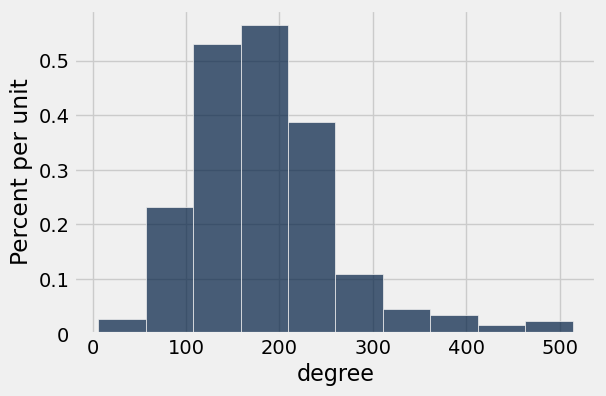

In [188]:
# BEGIN SOLUTION NO PROMPT
moc_data.hist('degree')
# END SOLUTION
""" # BEGIN PROMPT
...
"""; # END PROMPT

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 9

Make a histogram that shows the distribution of betweenness for moc_data table.



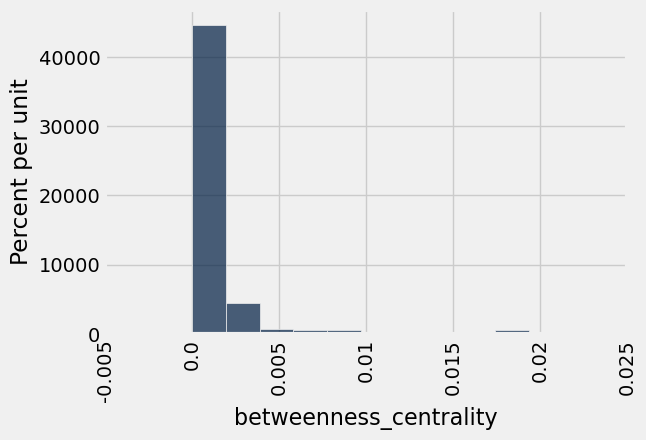

In [190]:
# BEGIN SOLUTION NO PROMPT
moc_data.hist('betweenness_centrality')
# END SOLUTION
""" # BEGIN PROMPT
...
"""; # END PROMPT

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 10 

Make a histogram that shows the distribution of eigenvector centrality.

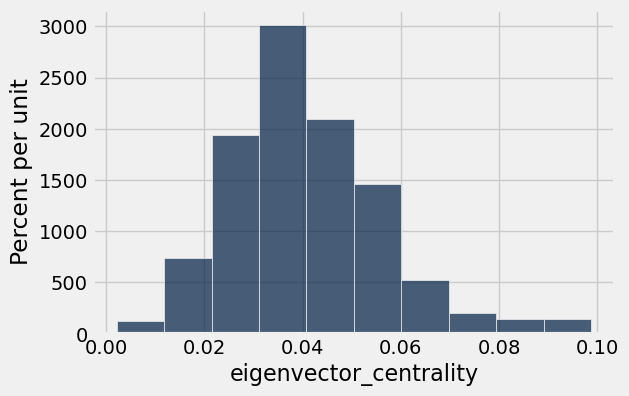

In [192]:
# BEGIN SOLUTION NO PROMPT
moc_data.hist('eigenvector_centrality')
# END SOLUTION
""" # BEGIN PROMPT
...
"""; # END PROMPT

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 11
Make a scatterplot that compares degree (x axis) and betweenness centrality.


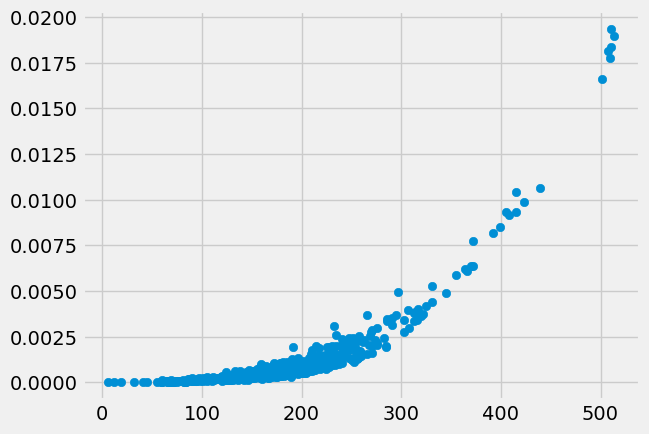

In [194]:
# BEGIN SOLUTION NO PROMPT
plt.scatter(moc_data['degree'], moc_data['betweenness_centrality']);
# END SOLUTION
""" # BEGIN PROMPT
plt.scatter(..., ...);
"""; # END PROMPT

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 12 

Make another scatterplot that compares degree (x axis) and eigenvector centrality.



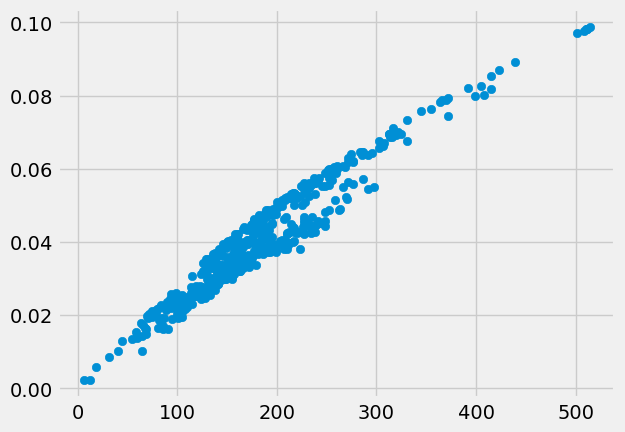

In [196]:
# BEGIN SOLUTION NO PROMPT
plt.scatter(moc_data['degree'], moc_data['eigenvector_centrality']);
# END SOLUTION
""" # BEGIN PROMPT
plt.scatter(..., ...);
"""; # END PROMPT

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 13

In one or two sentences, how would you describe the relationship between these different centrality measures?



_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Using epidemic models to understand centrality

The plots you made above show that the three different metrics of centrality (degree, eigenvector centrality, and betweenness centrality) do not all agree with each other. Our task now is to investigate which of these three quantities appears to be most effective for capturing how important a node is to the spread of an SIR epidemic on the MOC Twitter network.

One approach to this problem would be to try to analyze the SIR model mathematically: we could see if we could figure out which of the three metrics seems most closely related to the dynamics of the model. The alternative - which we will use here - is to use simulation to study this model. 

We will explore how innoculating nodes based on (1) their degree; and (2) their eigenvector centrality affects the expected size of an SIR epidemic on the MOC Twitter network. The idea is that if, for example, nodes' degrees are a good metric for centrality in an SIR epidemic, then innoculating nodes with high degree should be effective at slowing the spread of an SIR epidemic.

We'll start by bringing in several functions that we used in lab:

In [202]:
def set_status(net, ids, value):
    """
    set the value of the 'status' attribute for the nodes with the given ids
    in the given network
    """
    nx.set_node_attributes(net,  
                           dict([x for x in zip(ids, [value]*len(ids))]),
                          'status')

def get_status(net, ids):
    """
    get the value of the 'status' attributes for the nodes 
    with given ids in the given network
    """
    dat = nx.get_node_attributes(net, 'status')
    return([dat[x] for x in ids])

def count_infected_nodes(net):
    return(np.sum(np.array(list(nx.get_node_attributes(net, 'status').values())) == 'infected'))

def sim_epidemic(net, start_nodes=None, innoculated_nodes=None, beta=0.3, draw=False):
    
    # all nodes start susceptible
    set_status(net, net.nodes(), 'susceptible')

    # innoculated nodes start as recovered
    if innoculated_nodes is not None:
        set_status(net, innoculated_nodes, 'innoculated')
    else:
        innoculated_nodes = []

    eligible_to_start = [x for x in net.nodes() if x not in innoculated_nodes]        
        
    # if no start_nodes specified, pick one node at random as the seed
    if start_nodes is None:
        infected_nodes = np.random.choice(eligible_to_start, 1)
    else:
        infected_nodes = start_nodes

    
    set_status(net, infected_nodes, 'infected')

    incidence = [len(infected_nodes)]
    
    if draw:
        status_cmap = {'susceptible' : '#00FF00', 'infected' : '#FF0000', 'recovered' : '#000000', 'innoculated' : '#0000FF'}
        pos = nx.random_layout(net)
        
        #fig_nums = []

    while count_infected_nodes(net) > 0:

        if draw:
            next_fig, next_ax = plt.subplots() 
            plt.figure(nx.draw(net, 
                               pos=pos,
                               cmap=status_cmap, 
                               node_color=[status_cmap[net.node[node]['status']] for node in net]));
            #nx.draw(net, 
            #                   pos=pos,
            #                   cmap=status_cmap, 
            #                   node_color=[status_cmap[net.node[node]['status']] for node in net],
            #                   ax=next_ax)
            #fig_nums.append(plt.gcf().number)
        
        ## get neighbors of infected nodes
        neighbors = [net.neighbors(x) for x in infected_nodes]

        # see http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
        neighbors = [item for sublist in neighbors for item in sublist]        
        neighbors_status = np.array(get_status(net, neighbors))

        ## set infected nodes to recovered
        set_status(net, infected_nodes, 'recovered')

        ## infect susceptible neighbors with probability beta x number of infected contacts
        ## (a node with more than one infected contact will have more than one draws at being infected here)
        neighbors = [x[0] for x in zip(neighbors, neighbors_status) if x[1] == 'susceptible']
        infect_draws = np.random.random_sample(len(neighbors))
        to_infect = list(np.array(neighbors)[np.where(infect_draws < beta)])

        num_infected_this_round = len(set(to_infect))
        
        set_status(net, to_infect, 'infected')
        infected_nodes = to_infect

        ## record number infected this round (also called incidence at this time step)
        incidence.append(num_infected_this_round)
    
    return incidence

And here are a couple of additional functions that will be helpful when we investigate innoculation strategies below:

In [204]:
## example usage
## get_top_k(moc_data, 'degree', 10)

def get_top_k(data, col, k):
    node_ids = data.sort(col, descending=True).take(np.arange(0,k)).column('node_id')
    return(node_ids)

## example usage
## get_random_k(moc_data, 10)

def get_random_k(data, k):
    node_ids = data.sample(k, with_replacement=False).column('node_id')
    return(node_ids)

### Simulating an SIR epidemic on the MOC Twitter network

To start, we'll get a baseline idea of how an SIR epidemic would unfold in the MOC Twitter network. We'll be working with the following parameter values:

In [207]:
num_vaccines = 300
beta_param = .01
num_sims = 3000

<!-- BEGIN QUESTION -->

# Question 14

Following the pattern from lecture, simulate `num_sims` SIR epidemics with $\beta=$`beta_param`. Then make a histogram of the distribution of the resulting number infected.  
*[NOTE: this will take about 5 minutes to run]*



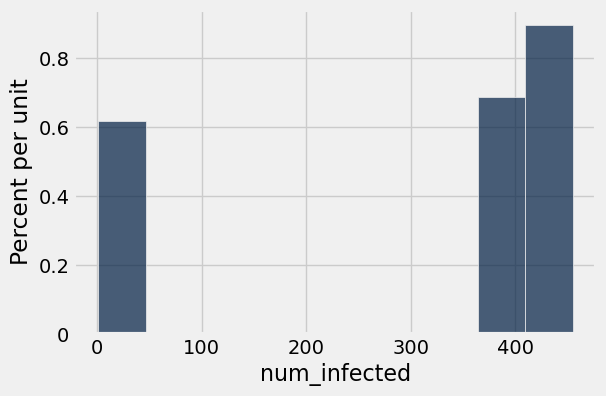

In [209]:
np.random.seed(99)
num_infected = make_array()

# BEGIN SOLUTION NO PROMPT
for _ in range(num_sims):
    num_infected = np.append(num_infected, np.sum(sim_epidemic(official_congress_twitter, beta=beta_param)))
# END SOLUTION
""" # BEGIN PROMPT
# Running this simulation will take about 3min...
for _ in range(...):
    num_infected = np.append(num_infected, np.sum(sim_epidemic(..., beta=...)))
"""; # END PROMPT
    
moc_sir_res_table = Table().with_column('num_infected', num_infected)
moc_sir_res_table.hist()

<!-- END QUESTION -->

# Question 15

Now summarize the SIR epidemic on the MOC Twitter network by calculating the mean number infected in the simulations you just ran.



In [211]:
# BEGIN SOLUTION NO PROMPT
moc_sir_mean_infected = np.mean(num_infected)
# END SOLUTION
""" # BEGIN PROMPT
moc_sir_mean_infected = np.mean(...)
"""; # END PROMPT

moc_sir_mean_infected

296.74366666666668

In [ ]:
grader.check("q15")

## Exploring innoculation strategies

Now that we have some understanding of how an SIR epidemic would unfold on the MOC Twitter network, we're going to try to compare different strategies for innoculating nodes in the network.
The idea is to use this approach to try and understand what characteristics make for **central** nodes in this network. We'll consider a node to be central if innoculating it reduces the expected size of the epidemic by a lot.

We're going to compare three different ways of measuring centrality: degree centrality, betweenness centrality, and eigenvector centrality. Our goal is to determine which of these three different centrality measures does the best job of telling us which nodes to innoculate in order to prevent the spread of an epidemic on this MOC Twitter network. We'll repeat each inoculation strategy many different times, each time changing the number of vaccines that we have to distribute. This will help us understand whether or not our conclusions depend on the budget.

Note that we're using the language of disease in this assignment, as we have in lecture. But the SIR model could describe the spread of anything that is governed by simple contagion. For example, in the case of the MOC Twitter network, it might be more interesting to think about information spreading through a simple contagion-type mechanism. In that case, this analysis helps us uncover the centrality metric that best predicts which Members of Congress are most important for the flow of information across the MOC Twitter network.

# **Question 16** 

The loop below tries different inoculation strategies many times across different parameter values. We compare strategies based on different measures of centrality to completely random innoculation. Fill in the missing pieces.   
*HINT: remember that we are testing innoculation strategies based on degree, betweenness, and eigenvector centrality*


[NOTE: This will take 1-2 minutes to run]



In [216]:
np.random.seed(99)
reps_per_param = 10

num_vaccines = np.repeat(np.array([50, 100, 150, 200, 250, 300, 350, 400]),
                         reps_per_param)

num_infected_random = make_array()
num_infected_degree = make_array()
num_infected_bc = make_array()
num_infected_ec = make_array()

for cur_num_vaccines in np.repeat(num_vaccines, reps_per_param):

# BEGIN SOLUTION NO PROMPT
        random_ids = get_random_k(moc_data, cur_num_vaccines)
        top_ec_ids = get_top_k(moc_data, 'eigenvector_centrality', cur_num_vaccines)
        top_bc_ids = get_top_k(moc_data, 'betweenness_centrality', cur_num_vaccines)
        top_degree_ids = get_top_k(moc_data, 'degree', cur_num_vaccines)

        num_infected_random = np.append(num_infected_random, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=random_ids)))
        
        num_infected_ec = np.append(num_infected_ec, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=top_ec_ids)))
        num_infected_bc = np.append(num_infected_bc, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=top_bc_ids)))
        num_infected_degree = np.append(num_infected_degree, 
                                        np.sum(sim_epidemic(official_congress_twitter, 
                                                            beta=beta_param,
                                                            innoculated_nodes=top_degree_ids)))
# END SOLUTION
""" # BEGIN PROMPT
        random_ids = get_random_k(moc_data, cur_num_vaccines)
        top_ec_ids = get_top_k(moc_data, ..., cur_num_vaccines)
        top_bc_ids = get_top_k(moc_data, ..., cur_num_vaccines)
        top_degree_ids = get_top_k(moc_data, ..., cur_num_vaccines)

        num_infected_random = np.append(num_infected_random, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=random_ids)))
        
        num_infected_ec = np.append(num_infected_ec, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=top_ec_ids)))
        num_infected_bc = np.append(num_infected_bc, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=top_bc_ids)))
        num_infected_degree = np.append(num_infected_degree, 
                                        np.sum(sim_epidemic(official_congress_twitter, 
                                                            beta=beta_param,
                                                            innoculated_nodes=top_degree_ids)))
"""; # END PROMPT

sim_results = Table().with_columns('num_vaccines', np.repeat(num_vaccines, reps_per_param),
                                  'num_infected_random', num_infected_random,
                                  'num_infected_degree', num_infected_degree,
                                  'num_infected_bc', num_infected_bc,
                                  'num_infected_ec', num_infected_ec)
sim_results

num_vaccines,num_infected_random,num_infected_degree,num_infected_bc,num_infected_ec
50,1,239,288,261
50,282,264,235,2
50,324,2,5,262
50,347,1,263,239
50,354,3,2,300
50,360,258,1,4
50,290,189,2,5
50,1,225,1,249
50,371,270,1,265
50,1,1,258,252


In [ ]:
grader.check("q16")

Next, let's look at the results of the simulation. In order to get a visually informative plot, we'll need to calculate the average outbreak size for each vaccination strategy and vaccine budget. Then we'll plot those averages.

# **Question 17** 

Calculate the average number infected for each value of `num_vaccines` and for each innoculation strategy.


In [221]:
# BEGIN SOLUTION NO PROMPT
sim_results_aggregate = sim_results.group('num_vaccines', np.mean)
# END SOLUTION
""" # BEGIN PROMPT
sim_results_aggregate = sim_results.group(..., np.mean)
"""; # END PROMPT

sim_results_aggregate

num_vaccines,num_infected_random mean,num_infected_degree mean,num_infected_bc mean,num_infected_ec mean
50,251.74,109.06,142.09,132.86
100,166.98,25.71,26.26,39.6
150,100.98,5.46,5.24,24.3
200,46.49,2.82,1.9,4.91
250,9.5,2.03,1.76,3.46
300,5.42,1.37,1.42,1.46
350,2.35,1.3,1.13,1.33
400,1.77,1.09,1.09,1.2


In [ ]:
grader.check("q17")

Take a look at the average number of infected people based on each innoculation strategy:

In [225]:
print('avg infected when innoculation based on:')
print('... degree: ', sim_results_aggregate.column('num_infected_degree mean').mean())
print('... betweenness centrality: ', sim_results_aggregate.column('num_infected_bc mean').mean())
print('... eigenvector centrality: ', sim_results_aggregate.column('num_infected_ec mean').mean())
print('... random:', sim_results_aggregate.column('num_infected_random mean').mean())

avg infected when innoculation based on:
... degree:  18.605
... betweenness centrality:  22.61125
... eigenvector centrality:  26.14
... random: 73.15375


Finally, let's plot the aggregate results:

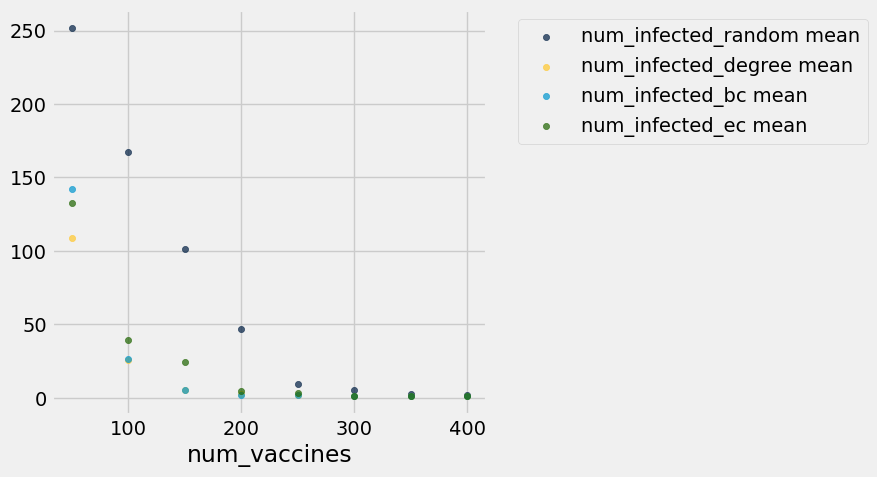

In [227]:
sim_results_aggregate.scatter('num_vaccines', overlay=True)

<!-- BEGIN QUESTION -->

# **Question 18** 

Based on these results, which innoculation strategy appears to be most effective across the range of vaccine budgets we investigated? Does this change your conclusion from before?


_Type your answer here, replacing this text._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)